# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(color_codes=True)

---
## 2. Load data

In [10]:
# load csv we created from task 2 with price sensitivity infomation
df = pd.read_csv('./cleaned_data_w_price_sen.csv', index_col=[0])

# Change dates in the dataframe into datetime type
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [11]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.03691,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.00000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.00000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

Below shows several feature engineering that can be added to the `df` for ML modelling using Random Forest
- Price sensitivity may not be contributing to the influence of churn
- look at other data trends instead of just price sensitivity 
### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [12]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [14]:
# Group off-peak prices by companies and month
# aggretate to calculate mean of off peak prices for every id and price date
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [19]:
# Get january and december prices
jan_price = monthly_price_by_id.groupby('id').first().reset_index() # for each id get the first price (Jan)
dec_price = monthly_price_by_id.groupby('id').last().reset_index() # for each id get the last price (Dec)

# Calculate the difference between dec and jan - both energy and power
off_price_diff = pd.merge(dec_price.rename(columns={'price_off_peak_var': 'dec_energy', 'price_off_peak_fix': 'dec_power'}), jan_price.rename(columns={'price_off_peak_var': 'jan_energy', 'price_off_peak_fix': 'jan_power'}).drop(columns='price_date'), on='id')
off_price_diff['offpeak_diff_dec_jan_energy'] = off_price_diff['dec_energy'] - off_price_diff['jan_energy']
off_price_diff['offpeak_diff_dec_jan_power'] = off_price_diff['dec_power'] - off_price_diff['jan_power']
off_price_diff = off_price_diff[['id', 'offpeak_diff_dec_jan_energy','offpeak_diff_dec_jan_power']]
off_price_diff.head()

,id,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [20]:
df = pd.merge(df, off_price_diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036910,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


### Average price changes (difference) across different periods

In [21]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [22]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [23]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_mid_peak,churn,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,16.365274,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


### Adding Tenure information
(How long company has been client of PowerCo): <br>
which clients of 4 or less months are more likely to churn compared to clients with longer period of time

In [29]:
df['tenure'] = ((df['date_end'] - df['date_activ']) / np.timedelta64(1, 'Y')).astype(int)

# visualise the trend of tenure and churn: averaging the churn and visualise in descending order
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


### Transform `has_gas` into Boolean (1, 0) for prediction
which without buying gas, are more likely to churn (by a small amount) 

In [30]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])

# visualise and see
df.groupby(['has_gas']).agg({'churn': 'mean'})


,churn
has_gas,
0,0.100544
1,0.081887


### Maximum price changes across periods and months

In [31]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [32]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [33]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [34]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,tenure,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,18.590255,7.450670,26.040925,3,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,44.311375,0.000000,44.311375,7,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,44.385450,0.000000,44.385450,6,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,44.400265,0.000000,44.400265,6,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,16.275263,8.137629,24.412893,6,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


### Transform categorical data (`channel_sales` and `origin_up`) - to put into prediction

In [37]:
# transform to category type
df['channel_sales'] = df['channel_sales'].astype('category')
df['channel_sales'].value_counts() 
# check how many categories within channel_sales - 8 categories in total

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [40]:
# add them all to separate columns, 
# but remove the last three categories since only very few items under them
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,0.085483,0.146033,44.266930,8.145775,44.26693,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0.085483,0.151367,44.444710,0.000000,44.44471,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0.089162,0.172468,44.444710,0.000000,44.44471,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0.000000,0.153133,44.444710,0.000000,44.44471,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0.033743,0.055866,16.291555,8.145775,24.43733,1,0,0,0,0


In [41]:
df['origin_up'] = df['origin_up'].astype('category')
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [42]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,8.145775,44.26693,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0.000000,44.44471,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0.000000,44.44471,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0.000000,44.44471,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,8.145775,24.43733,1,0,0,0,0,1,0,0


### Transform datetime type into months (numerical data) - for prediction model
Change dates into number of months __ until the reference date (next year start) 

In [55]:
def convert_datetime(ref_date, df, column):
    time_delta = ref_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [57]:
# reference date = next year start
ref_date = datetime(2016, 1, 1)

# create new months columns and remove the previous datetime columns
df['months_activ'] = convert_datetime(ref_date, df, 'date_activ')
df['months_end'] = convert_datetime(ref_date, df, 'date_end')
df['months_modif'] = convert_datetime(ref_date, df, 'date_modif_prod')
df['months_renewal'] = convert_datetime(ref_date, df, 'date_renewal')

df = df.drop(columns=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,months_activ,months_end,months_modif,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,1,30,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0,0,0,1,0,0,76,-7,76,4
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,1,0,0,1,0,0,68,-3,68,8
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0,1,0,1,0,0,69,-2,69,9
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,0,0,0,1,0,0,71,-2,71,9


### Correlations

<AxesSubplot:>

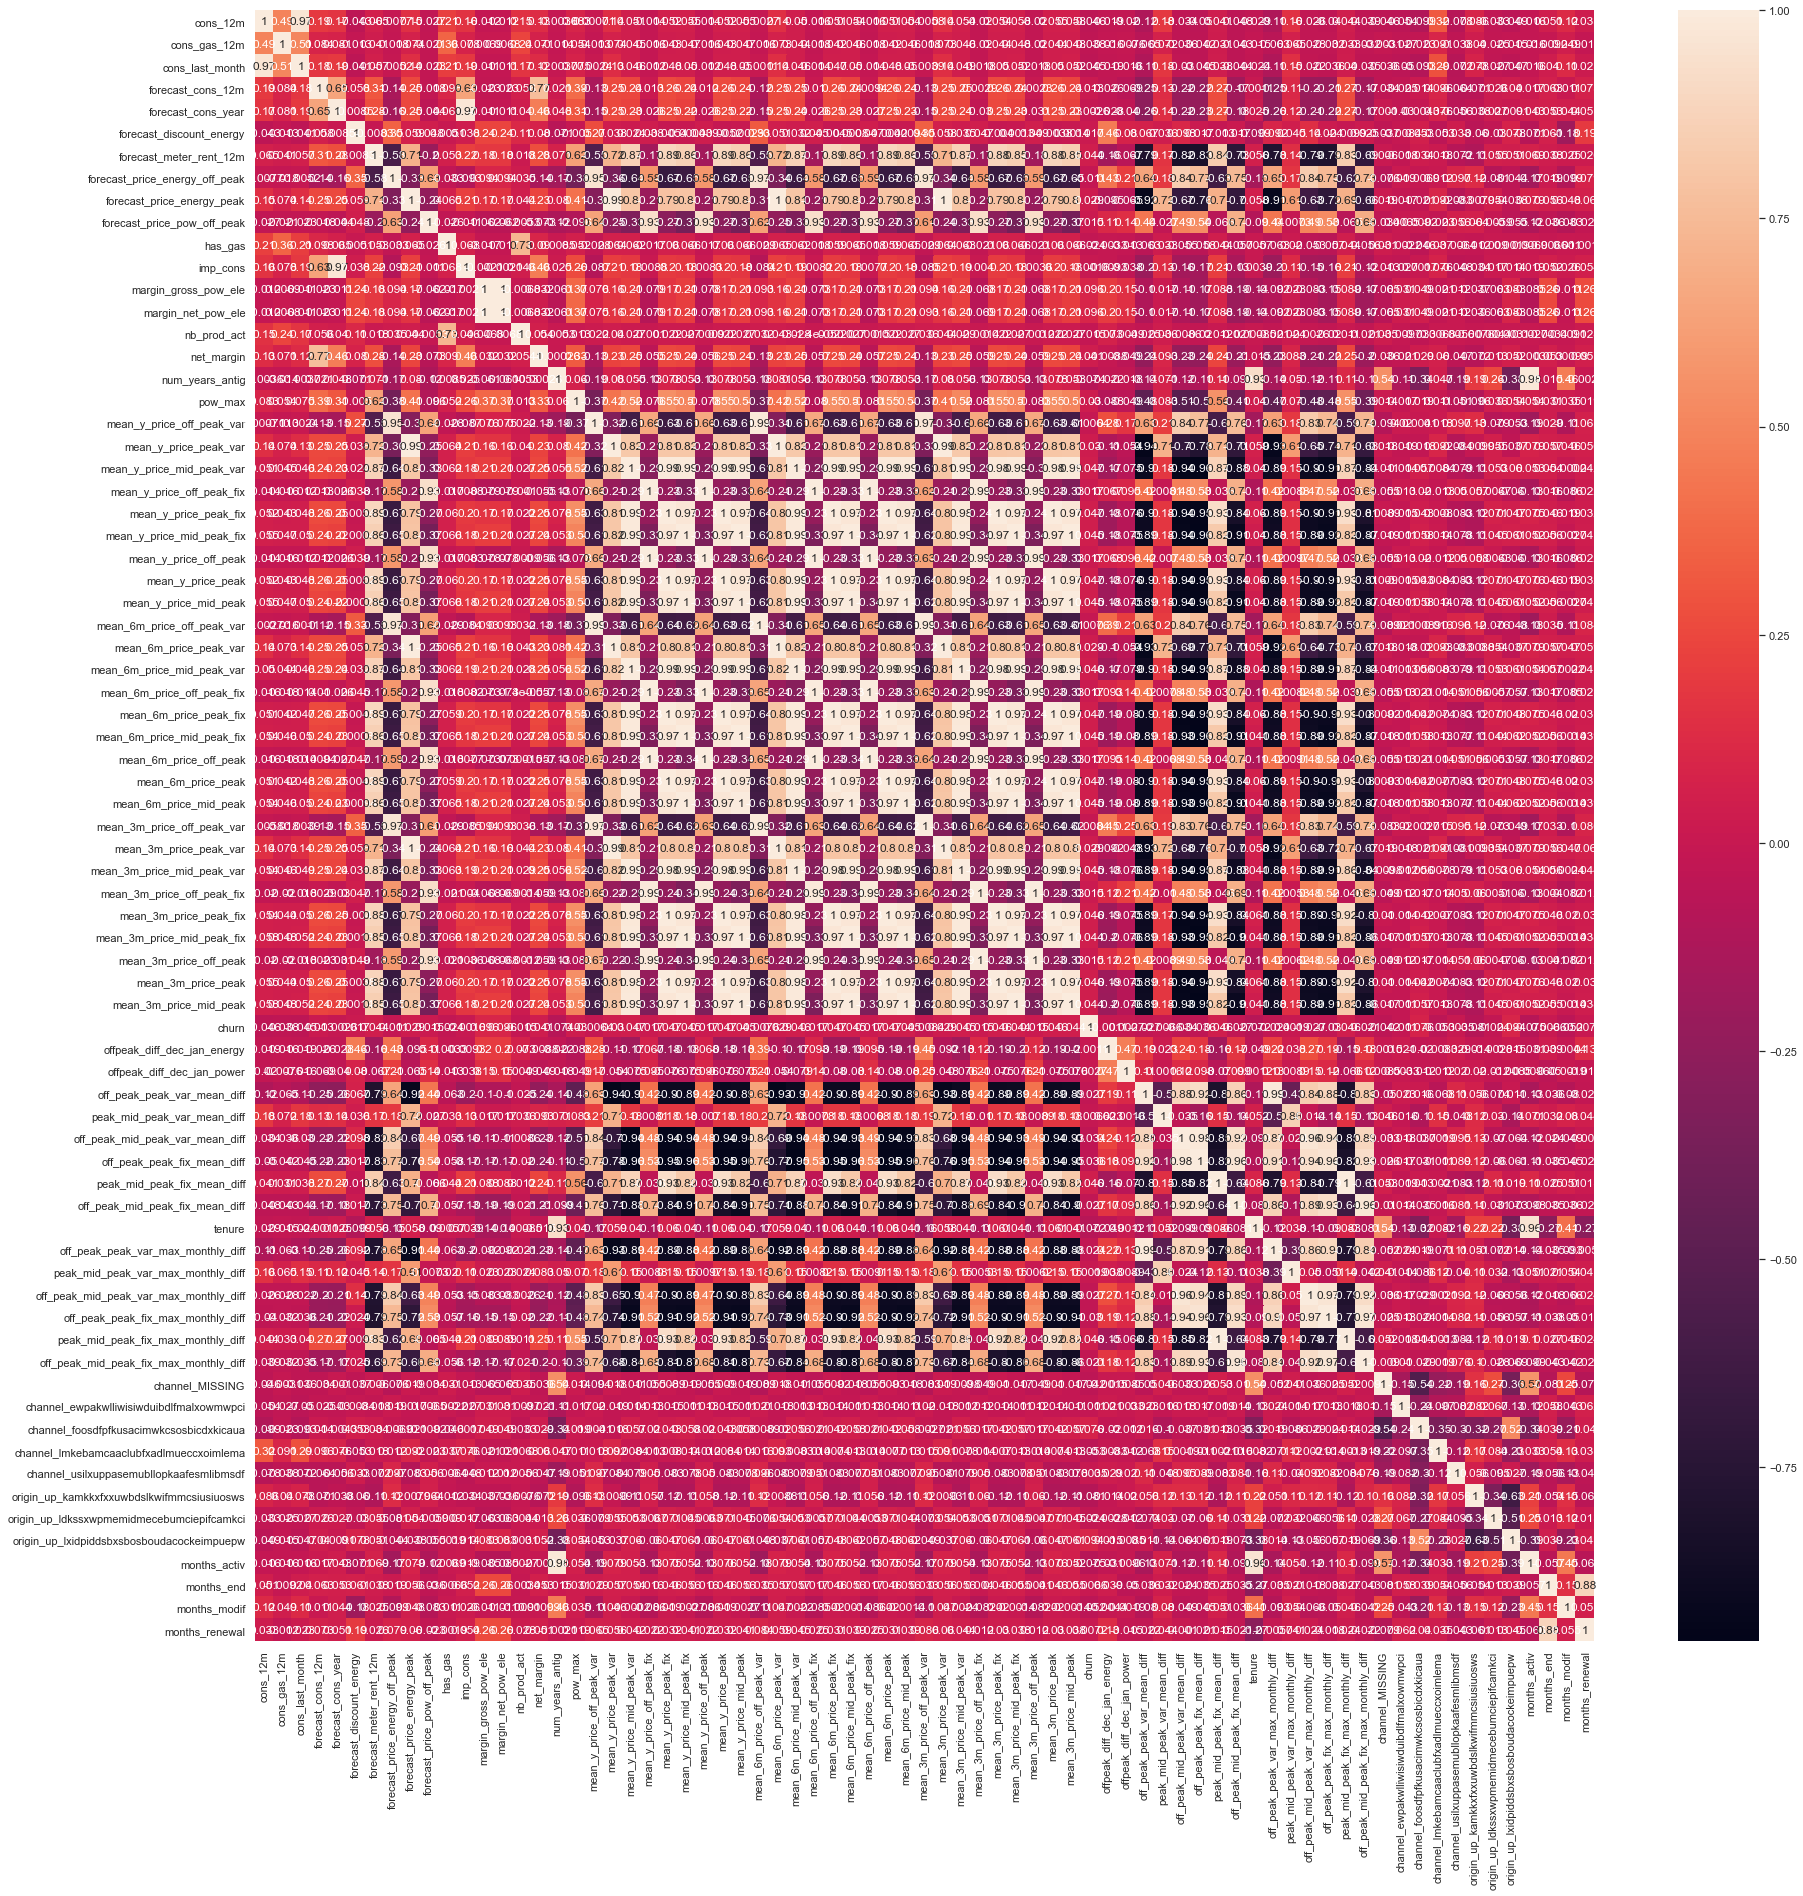

In [58]:
correlation = df.corr()

# plot correlations
plt.figure(figsize=(30, 30))
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, 
           annot=True, annot_kws={'size': 12})


## 5. ML Modelling - Random Forest 
Compared to decision trees:
- RF: train 1000 of decision trees, with different splits and learning different patterns
- Puts all to the overall views of the entire collections of decision trees
- increase number of learners -> should converge to its best possible solution 

In [59]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [60]:
train_df = df.copy()

In [61]:
# define target and independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14605, 72)
(14605,)


In [62]:
# define both train and test set (supervised learning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 72)
(10953,)
(3652, 72)
(3652,)


### Model training (with 1000 estimators) 

In [65]:
model = RandomForestClassifier(n_estimators=1000, verbose=2) 
# train 1000 of decision trees all using different splits of data and learning differen patterns
# 
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tre

building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tre

building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   39.7s finished


RandomForestClassifier(n_estimators=1000, verbose=2)

### Model evaluation
- Accuracy (ratio of correctly predicted observations to total observations) 
- Precision (ability of classifier to not label neg samples as pos) 
- Recall (ability of classifier to find all pos samples) 

In [85]:
prediction = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, prediction).ravel()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.1s finished


In [86]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 21
False positives: 2
True negatives: 3277
False negatives: 352



In [88]:
print(f"Accuracy: {metrics.accuracy_score(y_test, prediction)}")
print(f"Precision: {metrics.precision_score(y_test, prediction)}")
print(f"Recall: {metrics.recall_score(y_test, prediction)}")

Accuracy: 0.9030668127053669
Precision: 0.9130434782608695
Recall: 0.05630026809651475


### Output prediction for test dataset

In [102]:
prob_prediction = model.predict_proba(X_test)
prob_prediction

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.0s finished


array([[0.423, 0.577],
       [0.782, 0.218],
       [0.995, 0.005],
       ...,
       [0.941, 0.059],
       [0.869, 0.131],
       [0.914, 0.086]])

In [104]:
# only get the churn=1 probability 
churn_probabilities = prob_prediction[:, 1] 
churn_probabilities

array([0.577, 0.218, 0.005, ..., 0.059, 0.131, 0.086])

In [106]:
X_test['churn'] = prediction.tolist()
X_test['churn_proability'] = churn_probabilities.tolist()
X_test.head()

<ipython-input-106-f212b0cbb113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['churn'] = prediction.tolist()
<ipython-input-106-f212b0cbb113>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['churn_proability'] = churn_probabilities.tolist()


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,months_activ,months_end,months_modif,months_renewal,churn,churn_proability
4947,507715,0,51900,0.00,0,0.0,145.67,0.120372,0.103487,40.606701,...,0,0,0,1,35,-12,35,0,1,0.577
5868,1001492,159816,112397,658.07,1161,0.0,19.52,0.144902,0.000000,44.311378,...,0,0,1,0,67,-4,67,7,0,0.218
6805,0,0,0,0.00,0,0.0,132.59,0.092453,0.086393,59.173468,...,0,0,1,0,90,-11,90,0,0,0.005
1323,22152,0,0,3285.17,0,0.0,19.18,0.142996,0.000000,44.311378,...,0,0,0,1,70,-1,0,10,0,0.085
11759,1591,0,304,332.51,304,0.0,16.32,0.141434,0.000000,44.311378,...,0,0,0,1,40,-8,5,3,0,0.223


In [107]:
X_test.to_csv('prediction_result_testdata.csv')

### Model understanding by looking at feature importance

In [90]:
feature_importance = pd.DataFrame({
    'data_features': X_train.columns, 
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

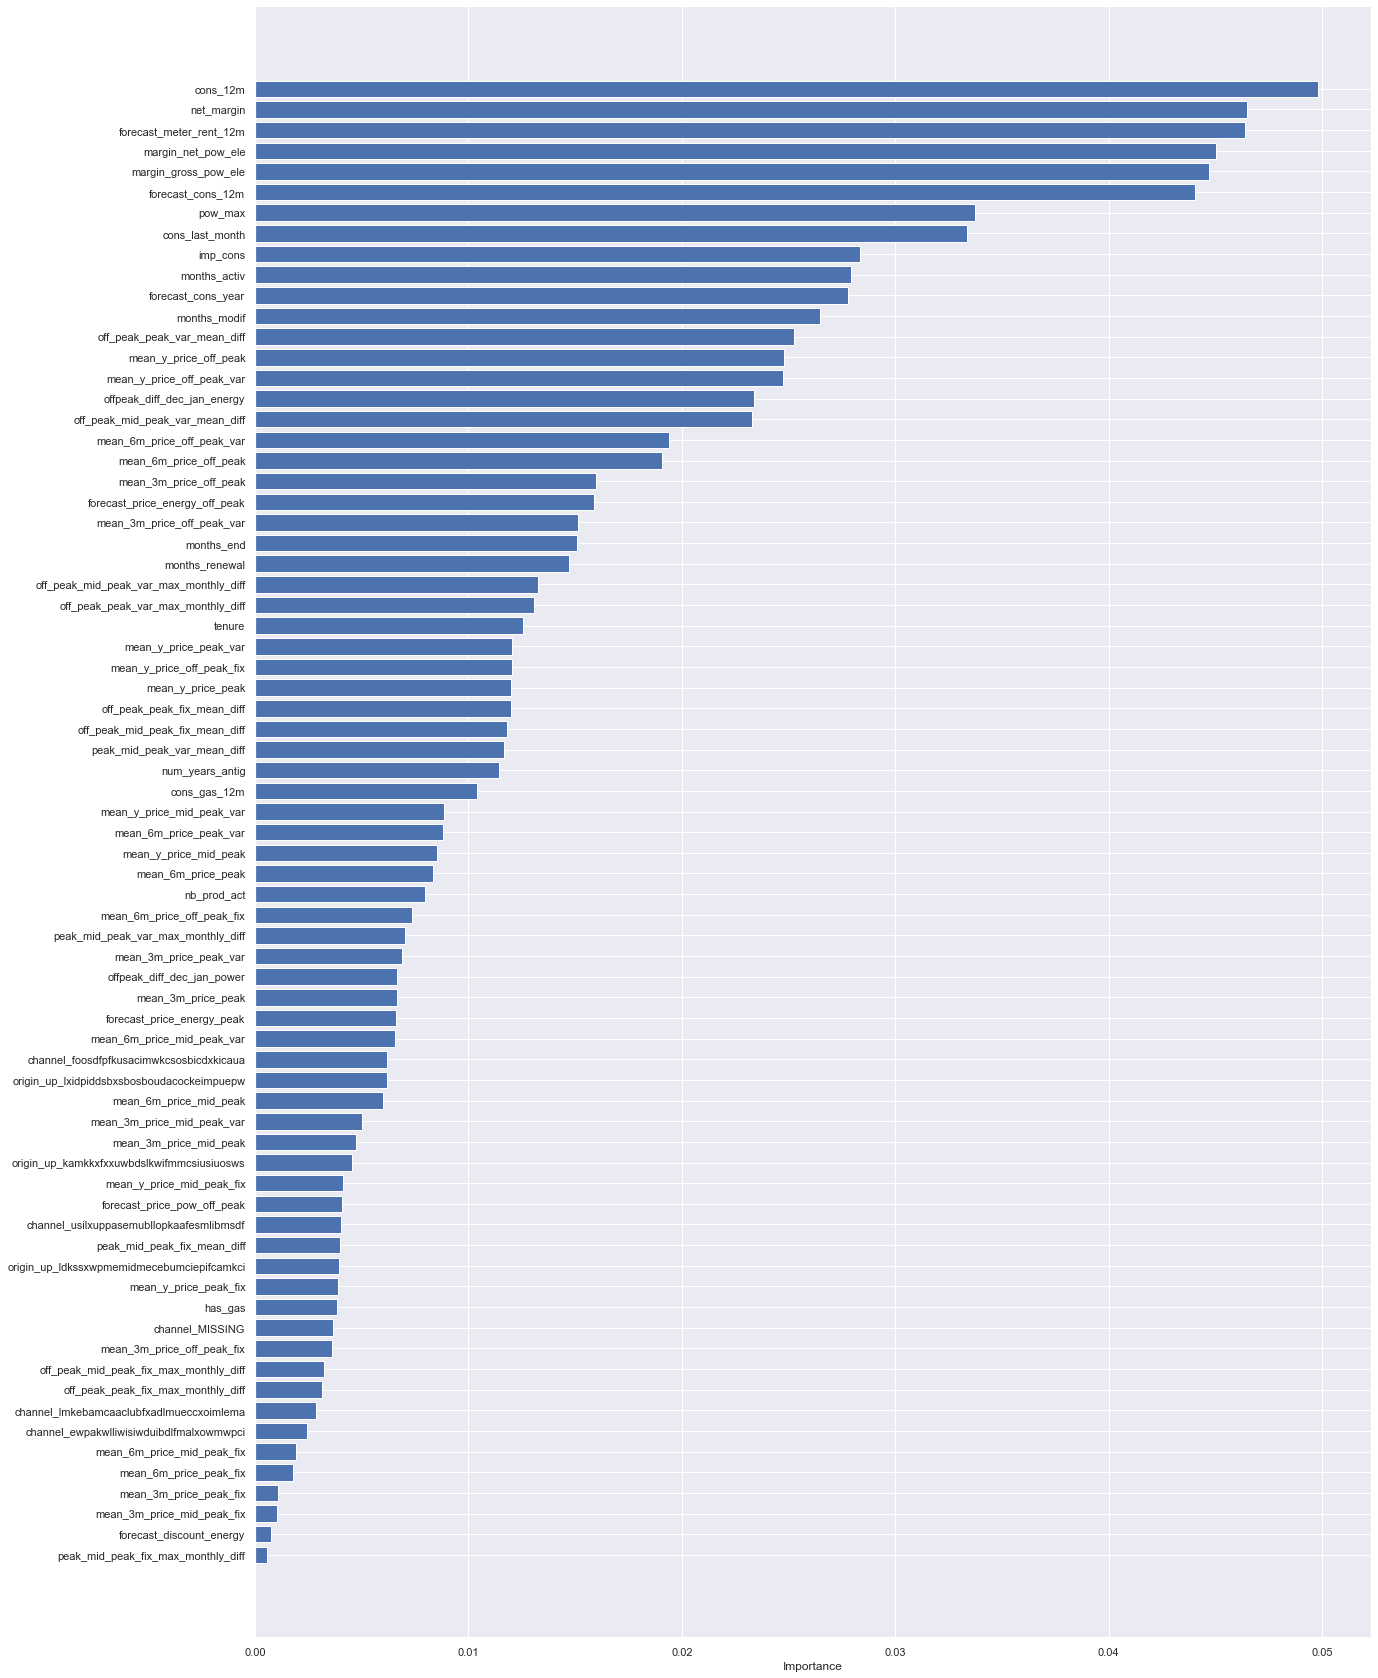

In [99]:
plt.figure(figsize=(20, 30))
plt.barh(range(len(feature_importance)), feature_importance['importance'], align='center')
plt.yticks(range(len(feature_importance)), feature_importance['data_features'])
plt.xlabel('Importance')
plt.show()